In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-bengali/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-bengali/classification')

In [6]:
!ls

Bengali_Classification_Model.ipynb	      models
Bengali_News_Classification_Data_cleaned.csv  tmp
Bengali_News_Classification_Data.csv


In [7]:
df = pd.read_csv(path/'Bengali_News_Classification_Data.csv')
df.tail()

,title,article,label
14200,"সংখ্যালঘু ভোটব্যাঙ্কে ভাঙন, ড্যামেজ কন্ট্রোলে ...",শহিদ মিনারে সিদ্দিকুল্লার সভা। আমন্ত্রিত মুখ্...,kolkata
14201,"মামির সঙ্গে স্বামীর বিবাহ বর্হিভূত সম্পর্ক, মা...",নিজস্ব প্রতিবেদন: মামির সঙ্গে এক বিছানায় স্বা...,kolkata
14202,"কলকাতায় জি মিডিয়ার সাংবাদিকতা শিক্ষার কোর্স, চ...",বিশেষ প্রতিবেদন: দেশের বৃহত্তম খবরের নেটওয়ার্ক...,kolkata
14203,মাধ্যমিকে ভালো রেজাল্ট করার স্বপ্ন নিয়েই অকালে...,চোখে অনেক স্বপ্ন ছিল। সামনে মাধ্যমিক। তাতে ভা...,kolkata
14204,"জটে জটিল ফ্লাইওভার প্রকল্প, দিনভর রাস্তায় ভিড়...","ফের জটে জটিল, রাজ্য সরকারের একটি ফ্লাইওভার প্...",kolkata


In [8]:
df['label'].unique()

array(['international', 'state', 'national', 'entertainment', 'kolkata', 'sport', 'sports', 'travel', 'world',
       'nation'], dtype=object)

In [9]:
for label in df['label'].unique():
    print(label, (df['label'] == label).sum())

international 664
state 2775
national 1794
entertainment 1492
kolkata 5793
sport 20
sports 1637
travel 1
world 14
nation 15


In [10]:
df['title'][0]

'শান্তি চেয়ে ট্রাম্প বেথলেহেমে'

In [11]:
df.shape

(14205, 3)

In [12]:
df[df['title'].isnull()].shape, df[df['article'].isnull()].shape

((0, 3), (49, 3))

In [13]:
df = df.dropna()

In [14]:
df[df['title'].isnull()].shape, df[df['article'].isnull()].shape

((0, 3), (0, 3))

In [15]:
df.to_csv('Bengali_News_Classification_Data_cleaned.csv', index=False)

In [16]:
label_cols = list(range(2,df.shape[1]))

In [17]:
print(label_cols)

[2]


In [18]:
id_to_col = list(df.columns)

In [19]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [20]:
class BengaliTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/bengali_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [21]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/bengali_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [22]:
# 30,000 is the vocab size that we chose in sentencepiece
bengali_vocab = Vocab(itos)

In [23]:
tokenizer = Tokenizer(tok_func=BengaliTokenizer, lang='bn')

In [24]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [28]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='Bengali_News_Classification_Data_cleaned.csv', text_cols=[0,1], label_cols=label_cols, tokenizer=tokenizer, vocab=bengali_vocab)

/home/gaurav/anaconda3/envs/fastai-1/lib/python3.6/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
travel
  if getattr(ds, 'warn', False): warn(ds.warn)


In [29]:
data_lm.save()

In [26]:
bs=48

In [27]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [32]:
data_lm.show_batch()

idx,text
0,"▁x x bo s ▁শা ঁ ও লি ▁কোন ▁সমস্যার ▁কথা ▁বলছেন ▁জানি ▁না ▁: ▁সুবোধ ▁সরকার ▁কাজ ▁করতে ▁বাধা ▁পাচ্ছে ন ▁তিনি । ▁পশ্চিমবঙ্গ ▁বাংলা ▁আকা ডেমি র ▁সভাপতি ▁পদ ▁ছাড়তে ▁চেয়ে ▁এমন ই ▁বিস্ফোরক ▁অভিযোগ ▁তুলেছেন ▁শা ঁ ও লি ▁মিত্র । ▁কিন্তু ▁তাঁর ▁অভিযোগ ▁মানতে ▁না রাজ ▁বিশিষ্ট ▁কবি ▁সুবোধ ▁সরকার । ▁তাঁর ▁বক্তব্য , ▁‘ বর্তমানে ▁পশ্চিমবঙ্গ ▁বাংলা ▁আকাদেমি র ▁কোনও ▁পরিকাঠামো গত ▁সমস্যা ই ▁নেই"
1,"▁সামগ্রিক ▁পরিস্থিতি ▁নিয়ে ▁ইতিমধ্যে ই ▁রিপোর্ট ▁সংগ্রহ ▁করেছে ▁প্রধানমন্ত্রীর ▁দফতর । ▁তার সঙ্গে ▁রাজ্য ▁বিজেপি র ▁পাঠানো ▁এই ▁তথ্য । ▁বৈঠক ের ▁সময় ▁প্রধানমন্ত্রী ▁যদি ▁এই ▁প্রসঙ্গ ▁তোলেন । ▁যদি ▁জবাব ▁চান । ▁তবে ▁তা ▁রাজ্যের ▁পক্ষে ▁খুব এক টা ▁স্বস্তি র ▁যে ▁হবে ▁না , ▁তা ▁স্পষ্ট । ▁x x bo s ▁স্বেচ্ছা মৃত্যু র ▁আবেদন ▁বাংলার ▁এক ▁বৃদ্ধ ার , ▁কী ▁এমন ▁ঘট ল ▁তাঁর ▁জীবনে ▁ছেলের ▁অত্যাচার"
2,"িং ▁শুরু ▁করে ▁দিয়েছেন । ▁যাতে ▁পুজো র ▁মধ্যে ▁বৃষ্টি ▁হলেও ▁সেরা ▁থিম গুলো ▁যেন ▁মিস ▁না ▁হয়ে ▁যায় । ▁থিম ের ▁বাহার ে ▁ঝ ল মল ▁করছে ▁ বারোয়ারি ▁পুজো মণ্ডপ গুলি । ▁সেরা ▁পুজো র ▁সেরা ▁ছবি ▁আমরা ▁তুলে ▁ধর ছি ▁আপনাদের ▁সামনে । ▁x x bo s ▁অরণ্য ের ▁দিন রাত্রি ▁ও ▁আমা ডুবি ▁ধ ল ভূম গড় ▁ গ্ৰ াম ▁ টাকে ▁ডানহাতে ▁রেখে , ▁সু"
3,"▁মহম্মদ ▁সেলিম ের ▁মতো ▁শীর্ষ ▁নেতারা । ▁সকালে ▁চি ড়িয়া মো ড় ▁থেকে ▁পার্ক সার ্ কাস , ▁গড়িয়া ▁থেকে ▁পার্ক সার ্ কাস , ▁খিদিরপুর ▁থেকে ▁তারা তলা ▁পর্যন্ত ▁r al l y ▁করবেন ▁নেতাকর্মী রা । ▁পাশাপাশি ▁পদযাত্রা ▁হবে ▁বেহালা র ▁শীল পাড়া ▁থেকে ▁তারা তলা , এবং ▁গার্ডেন রিচ ▁থেকে ▁ফতেপুর ▁বাজার ▁পর্যন্ত ও । ▁ভোট ের ▁আগে ▁নেতা , কর্মী দের ▁চা ঙ্গা ▁করতে"
4,"▁২০১১ ▁সালে ▁মারা ▁যান ▁স্টিভ ▁জো বস । ▁সম্প্রতি , ▁বস্টন ের ▁এক ▁অ কশন ▁হাউজ ▁জনসমক্ষে ▁এনেছে ▁তাঁরই ▁একটি ▁চাকরির ▁দরখাস্ত । ▁এই ▁বিষয়ে ▁অন্যান্য ▁খবর ▁মৃত্যুর ▁আগে ▁স্টিভ ▁জো বস ▁এই ▁অদ্ভুত ▁কথা গুলি ই ▁বলেছিলেন ▁জু কে র বার্গ কে ▁এই ▁মন্দিরে ▁আসার ▁পরামর্শ ▁দিয়েছিলেন ▁স্টিভ ▁জো বস । ▁তার ▁পর ... ▁জানেন , ▁‘‘ আই ▁ফোন ’’ - এর ▁i - এর ▁মানে ▁কী ?"


In [33]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [34]:
# Loading the pretrained language model on bengali wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-bengali/language-model/BengaliDataset/models/third_bn_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (11324 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-bengali/classification
x: LMTextList (11324 items)
[Text ▁x x bo s ▁ছ ’ বার ▁ভোটে ▁জিতেছেন । ▁মহিলাদের ▁থেকে ▁অভিনব ▁‘ উপ হার ’ ▁পাচ্ছে ন ▁এই ▁বিধায়ক ▁তিনি ▁রাজ্যের ▁বিধায়ক । ▁কিন্তু ▁বেলা গাম ▁তাঁর ▁মুখ । ▁এমনকী , ▁মহিলাদের ▁সম্পর্কে ▁কু কথা ▁বলতে ও ▁এত টুকু ▁বাধে ▁না ▁তাঁর । ▁সেই ▁কারণেই ▁এখন ▁মহিলাদের ▁রো ষ ের ▁মুখে ▁পড়েছেন ▁কেরল ের ▁নির্দল ▁বিধায়ক ▁পি ▁সি ▁জর্জ । ▁এ হেন ▁রাজনীতিবিদ ের ▁মুখ ▁বন্ধ ের ▁জন্য ▁অবশ্য ▁অভিনব ▁পথ ▁বেছে ▁নিয়েছেন ▁মহিলারা । ▁সোশ্যাল ▁মিডিয়া য় ▁ওই ▁বিধায়ক কে ▁উদ্ দেশ ▁করে ▁টেপ ▁পাঠ াচ্ছেন ▁তাঁরা । ▁এই ▁বিষয়ে ▁অন্যান্য ▁খবর ▁বন্যা ▁বিধ্বস্ত ▁কেরল ে ▁জেগে ▁উঠল ▁‘ ঈশ্বর ের ▁হাত ’ ! ▁বিস্ময় ে ▁মিডিয়া - জগৎ ▁ঘটনার ▁সূত্রপাত ▁কয়েকদিন ▁আগে । ▁জলন্ধর ের ▁এক ▁যাজক ের ▁বিরুদ্ধে ▁ধর্ষণ ের ▁অভিযোগ ▁এনেছে ন ▁কেরল ের ▁৪৬ ▁বছর ▁বয়স ি ▁এক ▁সন্ন্যাস িনী । ▁তাঁর ▁সম্পর্কে ই ▁চূড়

In [35]:
# Fine tuning the prtrained LM on current dataset

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


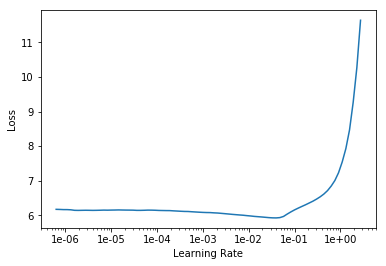

In [38]:
learn.recorder.plot()

In [39]:
learn.freeze()

In [40]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.984922,4.835206,0.242957


In [41]:
learn.save('fit_head', with_opt=True)

In [42]:
learn.load('fit_head', with_opt=True);

In [43]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.677421,4.728995,0.252887
2,4.504758,4.600225,0.265070
3,4.384535,4.507072,0.275426
4,4.205651,4.441593,0.282614
5,4.090478,4.402443,0.287492
6,3.933447,4.382288,0.290511
7,3.800420,4.374316,0.292430
8,3.708075,4.371787,0.293431
9,3.659476,4.377090,0.293742
10,3.594312,4.380836,0.293604


In [45]:
learn.save('fine_tuned', with_opt=True)

In [46]:
learn.load('fine_tuned', with_opt=True);

In [47]:
learn.predict('সামগ্রিক পরিস্থিতি',n_words=10)

'সামগ্রিক পরিস্থিতি a - র ▁দল বিরোধী ▁কাজের তৃ ণ মূল ▁বিজেপি'

In [48]:
learn.save_encoder('fine_tuned_enc')

In [28]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='Bengali_News_Classification_Data_cleaned.csv', tokenizer=tokenizer, vocab=bengali_vocab, text_cols=[0,1], label_cols=label_cols)

In [50]:
data_clas.show_batch()

text,target
"▁x x bo s ▁কিছু ▁সত্যি , ▁কিছু ▁বানানো ▁আমি ▁কখনও ▁পলি টি ক্যাল ▁মিটিং ▁শুনতে ▁যাই ▁না । ▁কারণ ▁আমি ▁জানি ▁নেতারা ▁কী ▁বলবে ন ▁বা ▁বলতে ▁পারেন । ▁আপনি ▁যদি ▁নেতার ▁নাম ▁আর ▁কী ▁উপলক্ষে ▁মিটিং ▁হচ্ছে , ▁কবে ▁হচ্ছে ▁আমাকে ▁বলতে ▁পারেন ▁তাহলে ▁আমি ▁ঐ ▁নেতার ▁বক্তব্য ▁মোটামুটি ▁আপনাকে ▁বলে ▁দিতে ▁পারি । ▁কিন্তু ▁কয়েকদিন ▁আগে ▁হঠাৎ ▁ফে ঁ সে ▁গেল াম । ▁ জিপি ও -",kolkata
"▁x x bo s ▁চার ▁মগ জ ▁সিন্ধু - মা ▁থেকে ▁মা - গঙ্গা ▁পর্যন্ত ... ▁এক ▁সময় ▁মধ্য শিক্ষা ▁পর্ষদ ের ▁বাংলা ▁মিডিয়াম ে , ▁ক্লাস ▁ফাইভ ের ▁ইতিহাস ▁বইয়ের ▁সবচেয়ে ▁আলোচিত ▁বিষয় ▁ছিল ▁হরপ্পা - মহ ে ঞ্জো ▁দ ড় ো । ▁কারণ ▁ওই ▁চ্যাপ্টা র ▁থেকে ▁একটা ▁প্রশ্ন ▁‘ কম ন ’ ▁আসত ই । ▁হাফ - ইয়া ল্লি - অ্যা নু য়ালি ▁দু ’ টো তেই",entertainment
"▁x x bo s ▁ ঠা কুমার ▁বন্ধুরা ▁রা ধে ▁মারা ▁যেতে ▁ ঠা কুমার ▁আর ▁কোন ▁বন্ধু ▁রইল ▁না । ▁ফল ত ▁খুব ▁একা ▁হয়ে ▁গেল ▁ঠাক ুমা । ▁একদিন ▁আমাকে ▁ডেকে ▁কয়েকজন ের ▁নাম ▁বললে । ▁হুকুম ▁হল , ▁তাদের ▁খোঁজ ▁আনার । ▁সেই ▁সব ▁বাড়ি ▁গিয়ে ▁দেখা ▁গেল , ▁দুই ▁যুগ ▁আগেই ▁তারা ▁সকলে ▁দেহ ▁রেখেছে । ▁সেই ▁শুনে ▁ঠাক ুমা ▁উ দাস ▁গলায় ▁বলল , ▁‘",kolkata
"▁x x bo s ▁রাইড ▁অ্যা - লং ▁দিল্লি ▁থেকে ▁লন্ডন ! ▁একা ▁হাতে ▁গাড়ি ▁চালিয়ে ▁বিলেত ▁পৌঁছে ছিলেন ▁তিনি । ▁দিল্লি - নি বাসী ▁ নিধি ▁তি ওয়ারি । ▁সঙ্গী ▁হয়েছিলেন ▁তাঁর ▁দুই ▁বন্ধু । ▁রশ্মি ▁কো প্পা র ▁এবং ▁সৌম্য া ▁গো য়েল । ▁৯৫ ▁দিনের ▁সফরে ▁তাঁরা ▁পার ▁হয়েছেন ▁১৭টি ▁দেশ । ▁তাঁদের ▁গাড়ির ▁মাইল - মিটার ▁বলছে , ▁গাড়ি ▁চলেছিল ▁মোট ▁২৩ , ৮০০ ▁কিলোমিটার ।",entertainment
"▁x x bo s ▁বেলা ▁শুরু ▁এর ▁আগে ▁যত বার ই ▁আপনার ▁সাক্ষাৎকার ▁প্রকাশিত ▁হয়েছে , ▁শিব প্রসাদ ▁মুখোপাধ্যায় ▁বা ▁অন্য ▁কেউ ▁ছিলেন । ▁এই ▁প্রথম ▁কি ▁একক ▁সাক্ষাৎকার ▁দিচ্ছেন ? ▁ হা সি ) ▁অনেকদিন ▁আগে ▁একটা ▁বিদেশি ▁পত্রিকার ▁জন্য ▁সাক্ষাৎকার ▁দিয়ে ছিলাম । ▁তারপর ▁এই ▁প্রথম । ▁শোনা ▁যায় , ▁আড়ালে ▁থাকতে ▁পছন্দ ▁করেন । ▁বেশি ▁কথা ▁বলতে ও ▁পছন্দ ▁করেন ▁না ... ! ▁একদম ▁তাই !",entertainment


In [51]:
data_clas.sanity_check()

In [48]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [49]:
learn.load_encoder('fine_tuned_enc')

In [50]:
learn.freeze()

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


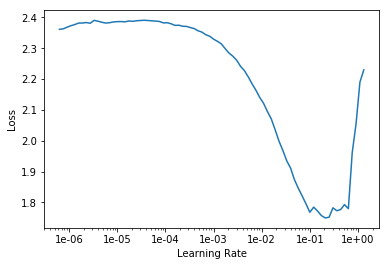

In [56]:
learn.recorder.plot()

In [51]:
learn.loss_func.func

CrossEntropyLoss()

In [52]:
kappa = KappaScore()

In [53]:
learn.metrics = [kappa, accuracy]

In [54]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.584281,0.479002,0.858354,0.893715


In [55]:
learn.save('first-full')

In [56]:
learn.load('first-full');

In [57]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.460690,0.297958,0.864176,0.897952
2,0.377553,0.246852,0.902268,0.926554
3,0.318541,0.281423,0.901437,0.926201
4,0.239060,1.425235,0.906230,0.929732
5,0.191959,0.772906,0.904317,0.928319


In [63]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.174126,0.692077,0.919174,0.939619
2,0.185606,1.132692,0.922597,0.942090
3,0.172064,0.280568,0.920143,0.940325
4,0.155645,1.012143,0.920242,0.940325
5,0.167418,1.097498,0.921518,0.941384


In [64]:
learn.save('final')

In [65]:
learn.predict('বেশ  কয়েক বছর আগের কলকাতা। বিবর্ণ পাড়া, বেরং বাড়ি, নোংরা সরু গলি। রঙের সমাহার নেই, নেই ঝলমলে আলোর রোশনাই। রয়েছে শুধু হৃদয়ের টান।')

(Category kolkata,
 tensor(2),
 tensor([3.5528e-03, 6.7437e-04, 9.6062e-01, 1.3069e-05, 2.5802e-03, 1.2976e-06,
         9.5950e-06, 3.2496e-02, 2.1062e-06, 4.6589e-05]))

In [66]:
learn.predict("প্রদর্শন বন্ধ করা যাবে না, ‘ভবিষ্যতের ভূত’ নিয়ে নির্দেশ সুপ্রিম কোর্টের")

(Category national,
 tensor(4),
 tensor([7.9605e-02, 1.4760e-03, 1.8172e-01, 2.3850e-04, 4.2016e-01, 4.0049e-05,
         1.7647e-03, 3.1499e-01, 2.3922e-06, 3.6156e-06]))

In [67]:
learn.predict("নিউজিল্যান্ডের মসজিদে হামলার ঘটনায় নিখোঁজ ৯ ভারতীয়")

(Category international,
 tensor(1),
 tensor([2.8247e-04, 7.7859e-01, 1.4554e-01, 1.0274e-04, 1.3884e-03, 2.6041e-03,
         5.2298e-02, 1.5781e-05, 3.4580e-06, 1.9172e-02]))

In [68]:
learn.predict("তৈরির উপাদান জানতে মিক্সারে ফোন গুঁড়ো করলেন বিজ্ঞানীরা")

(Category kolkata,
 tensor(2),
 tensor([5.3453e-03, 2.3468e-04, 9.9141e-01, 1.3866e-06, 4.5526e-04, 1.4638e-06,
         1.8572e-04, 2.3661e-03, 1.6758e-08, 6.4111e-07]))